In [102]:
%matplotlib inline 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import math
import copy

In [103]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [104]:
data = pd.read_csv('seattleWeather_1948-2017.csv')
data.head(5)

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


# Initial Data Cleaning

In [105]:
data.isna().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [106]:
data[(data.RAIN != True) & (data.RAIN!=False)]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


In [107]:
data = data[(data.RAIN == True) | (data.RAIN==False)]

In [108]:
labelencoder = LabelEncoder()
data['RAIN'] = labelencoder.fit_transform(data['RAIN'])

In [109]:
data['MONTH'] = pd.DatetimeIndex(data['DATE']).month
data['DAY'] = pd.DatetimeIndex(data['DATE']).day
data.head()

,DATE,PRCP,TMAX,TMIN,RAIN,MONTH,DAY
0,1948-01-01,0.47,51,42,1,1,1
1,1948-01-02,0.59,45,36,1,1,2
2,1948-01-03,0.42,45,35,1,1,3
3,1948-01-04,0.31,45,34,1,1,4
4,1948-01-05,0.17,45,32,1,1,5


# Preliminary Data Exploration

In [110]:
data.corr()

,PRCP,TMAX,TMIN,RAIN,MONTH,DAY
PRCP,1.000000,-0.226736,-0.064365,0.515160,0.014918,-0.001339
TMAX,-0.226736,1.000000,0.860675,-0.389241,0.154972,0.001726
TMIN,-0.064365,0.860675,1.000000,-0.139905,0.222504,0.003190
RAIN,0.515160,-0.389241,-0.139905,1.000000,-0.046046,-0.003148
MONTH,0.014918,0.154972,0.222504,-0.046046,1.000000,0.009639
DAY,-0.001339,0.001726,0.003190,-0.003148,0.009639,1.000000


None of these variable seems to have any correlation since all of the covariance is less 0.5

In [111]:
rain = data[data.RAIN == True]
norain = data[data.RAIN == False]

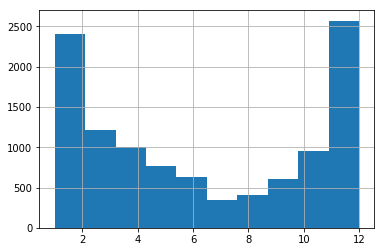

In [112]:
rain['MONTH'].hist()

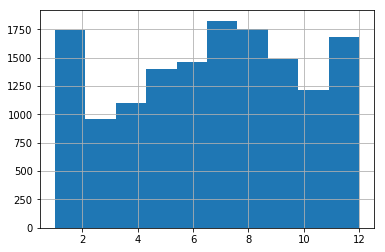

In [113]:
norain['MONTH'].hist()

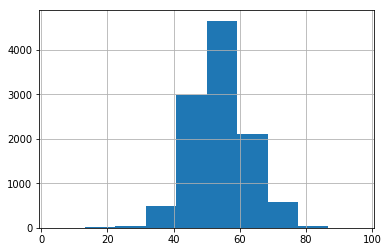

In [114]:
rain['TMAX'].hist()

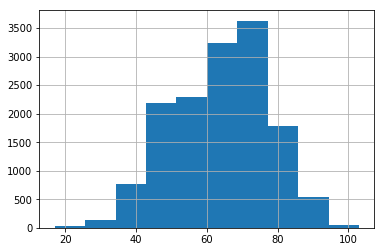

In [115]:
norain['TMAX'].hist()

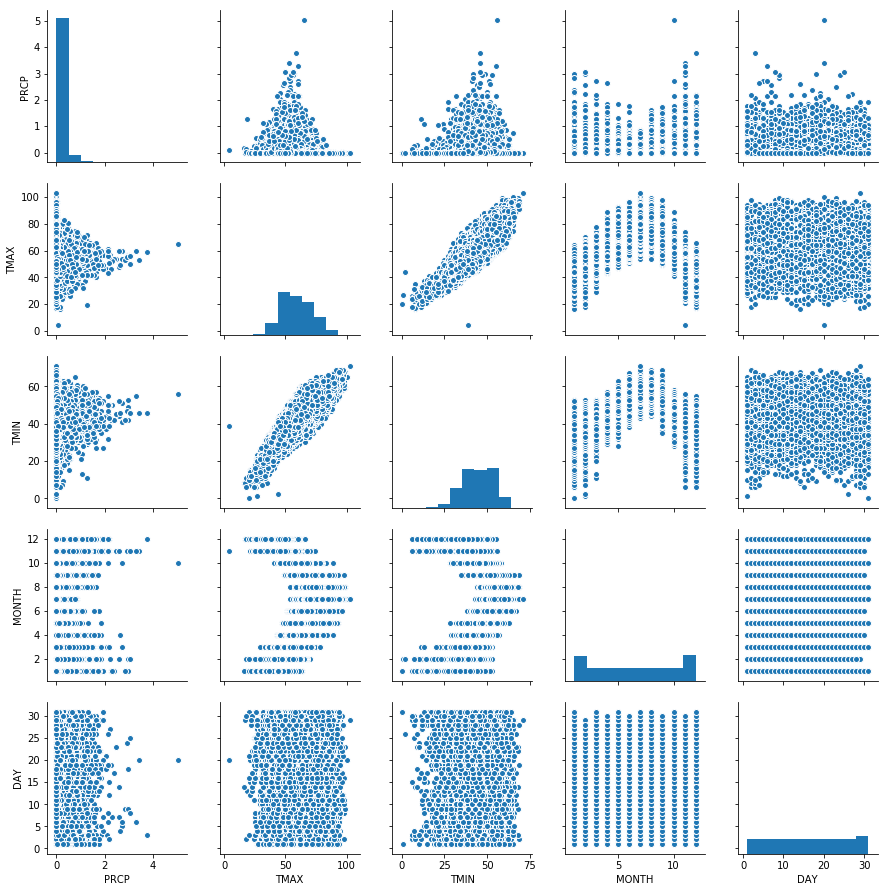

In [116]:
sns.pairplot(data=data[['PRCP','TMAX','TMIN','MONTH','DAY']])

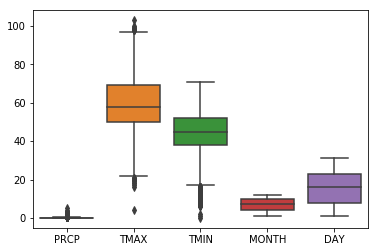

In [117]:
sns.boxplot(data=data[['PRCP','TMAX','TMIN','MONTH','DAY']])

There are some outliers in the graph, let see if we can take out the outliers by estimating the range of variable based on the box plots

In [118]:
dataN = data.copy()
dataN=dataN.drop(dataN[dataN['TMIN']<17 ].index)
dataN=dataN.drop(dataN[(dataN['TMAX']>97.5) | (dataN['TMAX']< 21.5)].index)
dataN=dataN.drop(dataN[(dataN['PRCP']>0.25) | (dataN['PRCP']< -0.15) ].index)

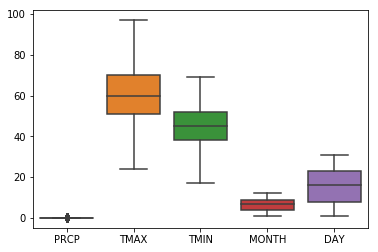

In [119]:
sns.boxplot(data=dataN[['PRCP','TMAX','TMIN','MONTH','DAY']])

We seem to have taken out of the outliers. We have also did some cleaning with the dataset as well.

# Cleaning

In [120]:
X = dataN[['PRCP','TMAX','TMIN','MONTH','DAY']].copy()
y = dataN['RAIN'].copy()

I did not use the dataN because I tried that out and it give a lower accuracy score, the original set of data with outliers seem to perform better with the models

# Transformation & Split

In [121]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
XScaletrain,XScaletest,yscaletrain,yscaletest = train_test_split(Xscale,y,test_size=0.2)

In [165]:
# len(ytest[ytest == 1]) /len(ytest)

In [166]:
# len(ytest[ytest == 0]) / len(ytest)

# Analyze
    False Positive is type II error, where the hypothesis is false but we fail to reject it.
    False Negative is type I error, where the hypothesis is true but we reject it.
    The common norm is that type I is worse than type II.

## SVM

array([0, 0, 1, ..., 0, 0, 0])

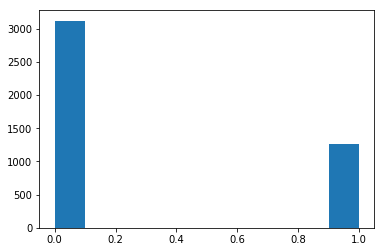

In [122]:
svc = SVC()
svc.fit(Xtrain,ytrain)
ypredS = svc.predict(Xtest)
plt.hist(ypredS)
ypredS

In [123]:
metrics.accuracy_score(ytest,ypredS)

0.7654179990863408

In [124]:
metrics.confusion_matrix(ytest,ypredS)
# TruePositive FalsePositive
# FalseNegative TrueNegative

array([[2508,  417],
       [ 610,  843]])

In [125]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredS) / len(ytest), cmap='Blues', annot=True)

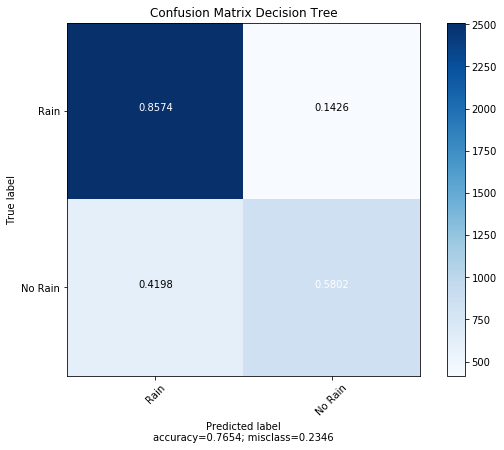

In [126]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest, ypredS),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [127]:
metrics.roc_auc_score(ytest,ypredS)

0.7188074187798895

In [128]:
svc = SVC()
svc.fit(XScaletrain,yscaletrain)
ypredscale = svc.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

1.0

In [129]:
metrics.confusion_matrix(yscaletest,ypredscale)

array([[2915,    0],
       [   0, 1463]])

In [130]:
# sns.heatmap(metrics.confusion_matrix(yscaletest, ypredscale) / len(ytest), cmap='Blues', annot=True)

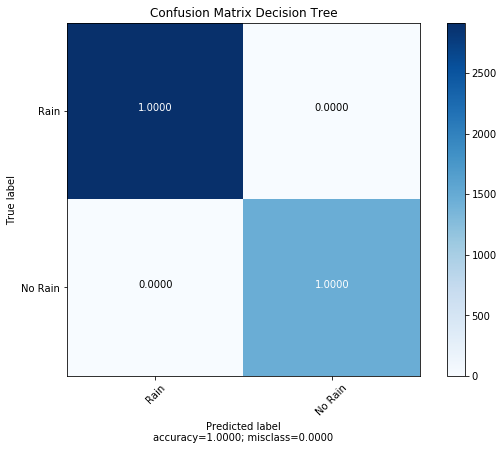

In [131]:
plot_confusion_matrix(cm = metrics.confusion_matrix(yscaletest, ypredscale),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

Scaling seem to improve the the accuracy

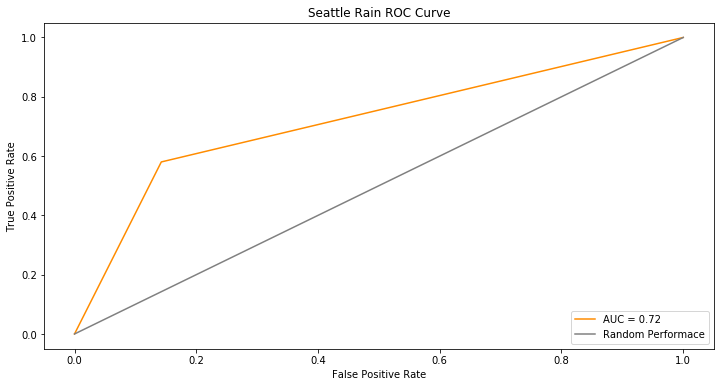

In [132]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredS)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

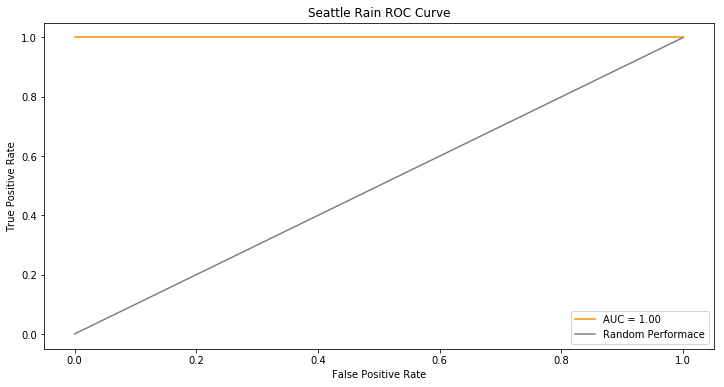

In [133]:
fpr, tpr, threshold = metrics.roc_curve(yscaletest, ypredscale)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

Scaling helps improve the performance of the test

## Logistic regression

(array([3274.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1104.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

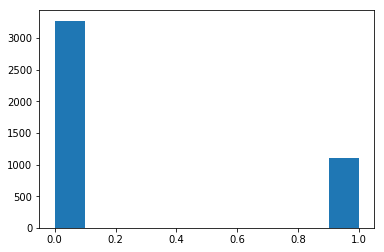

In [134]:
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypredL = lr.predict(Xtest)
plt.hist(ypredL)

In [135]:
metrics.accuracy_score(ytest,ypredL)

0.9120603015075377

In [136]:
metrics.confusion_matrix(ytest,ypredL)
# TruePositive FalsePositive
# FalseNegative TrueNegative

array([[2907,   18],
       [ 367, 1086]])

In [137]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredL) / len(ytest), cmap='Blues', annot=True)

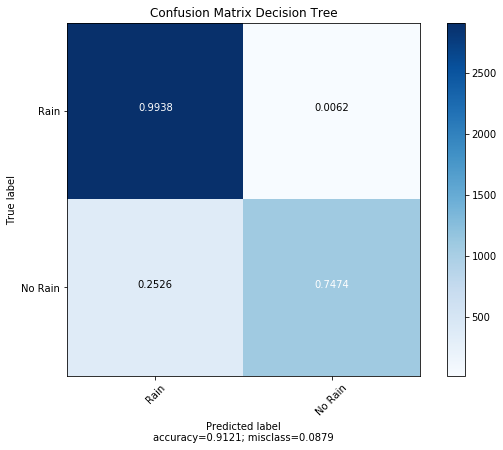

In [138]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredL),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [139]:
metrics.roc_auc_score(ytest,ypredL)

0.8706326433373921

In [140]:
lr = LogisticRegression()
lr.fit(XScaletrain,yscaletrain)
ypredscale = lr.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

0.9990863407948835

In [141]:
metrics.confusion_matrix(yscaletest,ypredscale)

array([[2915,    0],
       [   4, 1459]])

In [142]:
# sns.heatmap(metrics.confusion_matrix(yscaletest, ypredscale) / len(ytest), cmap='Blues', annot=True)

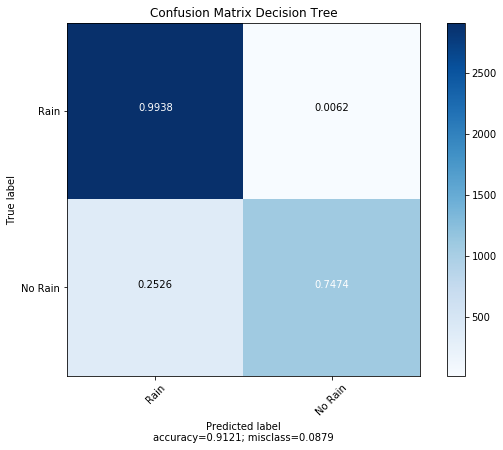

In [143]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredL),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

Scaling does help a bit but not a ton

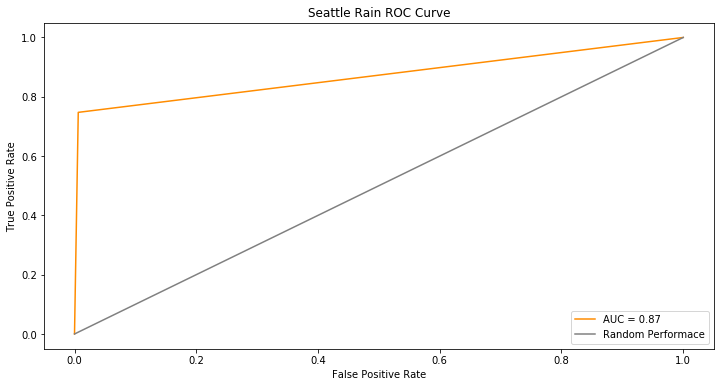

In [144]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredL)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

## Naive Bayes

(array([2925.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1453.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

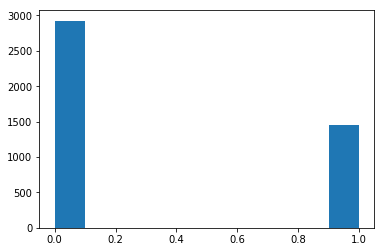

In [145]:
naive = GaussianNB()
naive.fit(Xtrain,ytrain)
ypredB = naive.predict(Xtest)
plt.hist(ypredB)

In [146]:
metrics.accuracy_score(ytest,ypredB)

1.0

In [147]:
metrics.confusion_matrix(ytest,ypredB)

array([[2925,    0],
       [   0, 1453]])

In [148]:
# sns.heatmap(metrics.confusion_matrix(ytest, ypredB) / len(ytest), cmap='Blues', annot=True)

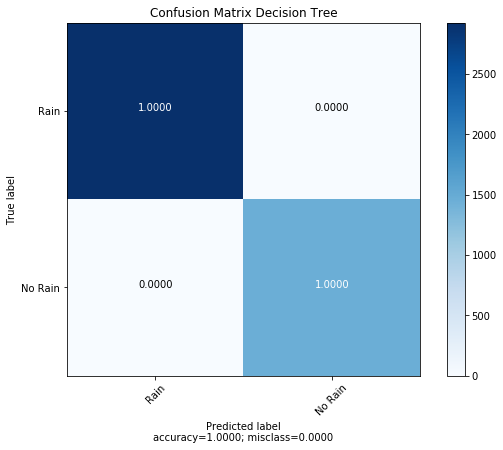

In [149]:
plot_confusion_matrix(cm = metrics.confusion_matrix(ytest,ypredB),normalize=True, target_names = ['Rain', 'No Rain'],title = "Confusion Matrix Decision Tree")

In [150]:
metrics.roc_auc_score(ytest,ypredB)

1.0

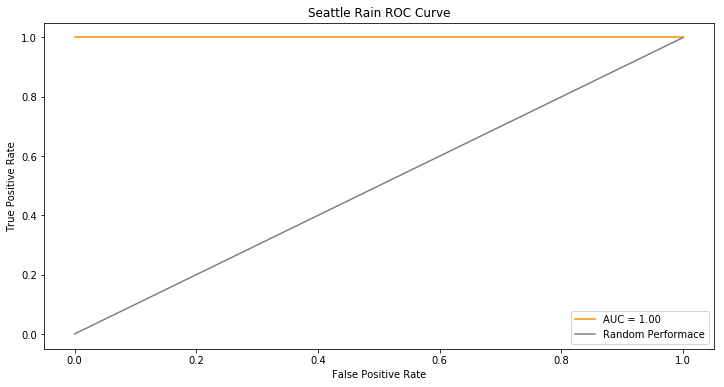

In [151]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredB)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc="lower right")

In [152]:
naive = GaussianNB()
naive.fit(XScaletrain,yscaletrain)
ypredscale = naive.predict(XScaletest)
metrics.accuracy_score(yscaletest,ypredscale)

1.0

Scaling does not impact the performance

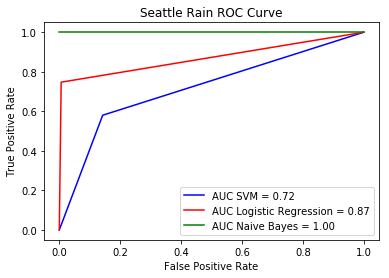

In [153]:
ypred = [ypredS,ypredL,ypredB]
test = ['SVM','Logistic Regression', 'Naive Bayes']
colors = ['blue','red','green']
for i in range(1, 4):
    fpr, tpr, threshold = metrics.roc_curve(ytest, ypred[i-1])
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[i-1], label = 'AUC '+test[i-1]+' = %0.2f' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Seattle Rain ROC Curve')
    plt.legend(loc="lower right")

# Conclusion: Naive Bayes performs the best with this dataset